In [1]:
import pandas as pd
%matplotlib inline
import matplotlib as plt
pd.set_option("display.max_columns",999)
import numpy as np
import json
import datetime

# Getting some info from JSON file

In [4]:
df = pd.read_pickle("../data/cuentalo_clean_1.pkl")

In [5]:
# filter old cited tweets 
#df=df[df['created_at']>=datetime.datetime(2018,4,27)]
extra_tweets = set()
with open("../data/tweets_faltantes_de_inferencia.csv") as fi:
    for line in fi:
        extra_tweets.add(int(line.strip()))
        

df = df[~df.id.isin(extra_tweets)]

In [6]:
len(df)

2111998

In [7]:
set(df.id.values).intersection(extra_tweets)

set()

### How many tweets per 5 minutes?

In [9]:
import matplotlib.pyplot as plt

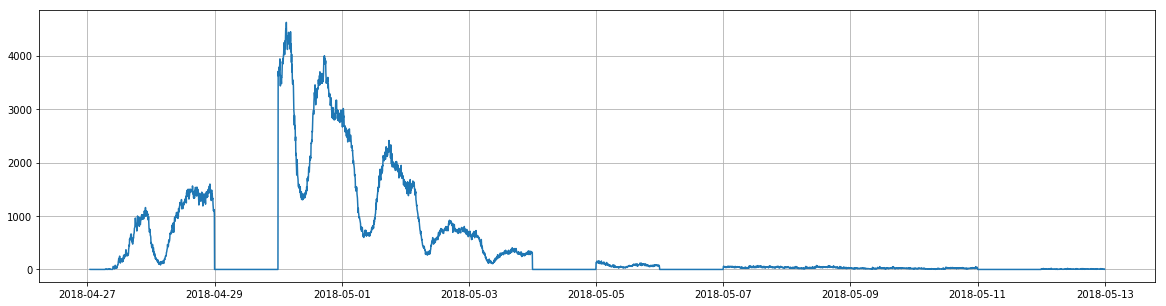

In [12]:
plt.figure(figsize=(20, 5))
plt.plot(df[['created_at','retweet_count']][df['created_at']>=datetime.datetime(2018,4,27)].set_index('created_at').resample('5T').count())
plt.grid(True)
plt.show()

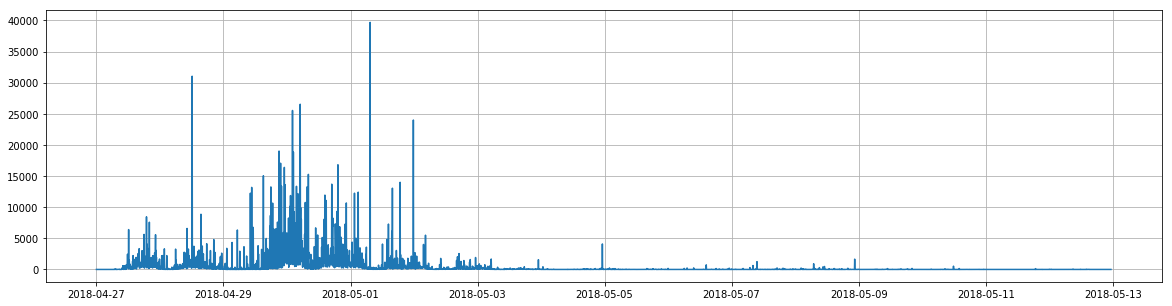

In [13]:
plt.figure(figsize=(20, 5))
plt.plot(df[['parent_created_at','retweet_count']][df['parent_created_at']>=datetime.datetime(2018,4,27)].set_index('parent_created_at').resample('5T').count())
plt.grid(true)
plt.show()

There are two days missing ? 29/4 and 4/5, reconstructed by the references to them from older tweets

Roughly a peak of 5K tweets is a lot. We could try a smaller time window but then horizontally we'll get too many points. (2 weeks at 5 min are 4032 points, every 2 minutes we have 10080)


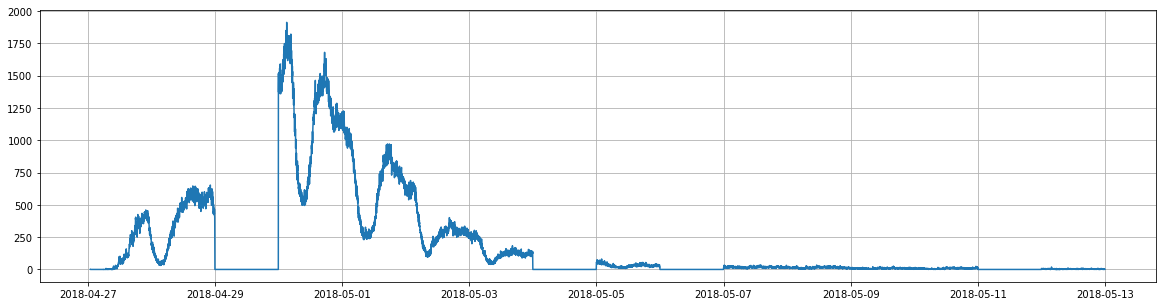

In [19]:
plt.figure(figsize=(20, 5))
plt.plot(df[['created_at','retweet_count']][df['created_at']>=datetime.datetime(2018,4,27)].set_index('created_at').resample('2min').count())
plt.grid(True)
plt.show()

### Analizing the nature of RTs
- How many types of tweets are there?

In [21]:
df.groupby('tweet_type')['id'].count()

tweet_type
original     111337
quote          8084
reply         19374
retweet     1973203
Name: id, dtype: int64

How do we check if the RT count is the same for each new RT?

In [23]:
grouped_originals = df[(df.tweet_type!="retweet") & (df['created_at']>=datetime.datetime(2018,4,27))]
grouped_retweets = df[(df.tweet_type=="retweet") & (df['created_at']>=datetime.datetime(2018,4,27))].groupby('parent_id')

Is that everything?

In [24]:
print('tweets originales',len(grouped_originals))
parent_ids=set(grouped_retweets['parent_retweet_count'].max().index)
print('tweets mencionados',len(parent_ids))
print('tweets mencionados que no están:',len(parent_ids.difference(set(grouped_originals.index))))

tweets originales 138795
tweets mencionados 62098
tweets mencionados que no están: 4867


Top 10 tweets by retweet count

In [28]:
pd.DataFrame(grouped_retweets['parent_retweet_count'].max().sort_values(ascending=False))
grouped_originals[grouped_originals.id.isin(df.parent_id.unique())][['retweet_count','user_screen_name','created_at']].sort_values('retweet_count',ascending=False)[:10]

,retweet_count,user_screen_name,created_at
990201907456208896,54705,martolius,2018-04-28 12:11:46
991217730601848834,44150,micaserrano23,2018-05-01 07:28:17
991464409825505280,33892,viickymonti,2018-05-01 23:48:30
990818114995703808,22633,rg_vianca,2018-04-30 05:00:21
990775116807229440,20483,sabri_barra,2018-04-30 02:09:30
990779462273953794,17764,cchaconj,2018-04-30 02:26:46
990325049893801984,17472,AlejandraTuk,2018-04-28 20:21:05
991034153268383751,17195,santygom3z,2018-04-30 19:18:49
990864702011006977,16094,victoriaEacosta,2018-04-30 08:05:28
990285709293572096,15873,anisbaron,2018-04-28 17:44:46


How many retweets per tweet?

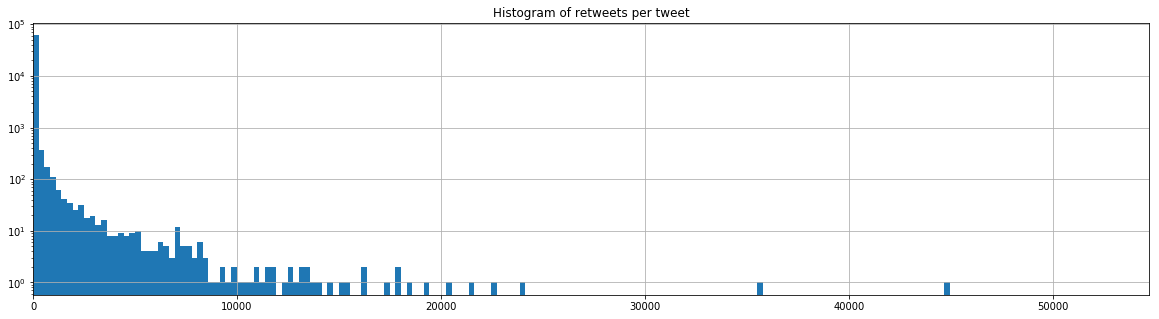

In [34]:
fig, ax = plt.subplots(figsize=(20, 5))
plt.title('Histogram of retweets per tweet')
grouped_retweets['retweet_count'].max().hist(bins=200, ax=ax).set_yscale('log')
plt.xlim([0, 54705])
plt.show()

In [35]:
grouped_originals['retweet_count'].sort_values(ascending=False).astype(int).head(10) 

990201907456208896    54705
991217730601848834    44150
991464409825505280    33892
990818114995703808    22633
990775116807229440    20483
990779462273953794    17764
990325049893801984    17472
991034153268383751    17195
990864702011006977    16094
990285709293572096    15873
Name: retweet_count, dtype: int64

In [37]:
grouped_retweets['retweet_count'].std()[:10]

parent_id
646602982713360384         NaN
747883568735600640         NaN
989554972697251845    0.100248
989604040525910017    0.000000
989759402767859712    0.000000
989759705344950273    0.000000
989762675411378177    0.000000
989764018779840518         NaN
989764409403756544    0.000000
989764518556319744         NaN
Name: retweet_count, dtype: float64

There are tweet IDs that change the number of retweets

In [38]:
(len(grouped_retweets['retweet_count'].std()[grouped_retweets['retweet_count'].std()>0]),
len(grouped_retweets['retweet_count'].std()[grouped_retweets['retweet_count'].std()==0]))

(2821, 32536)

In [40]:
grouped_retweets['retweet_count'].std()[grouped_retweets['retweet_count'].std()>0].head()

parent_id
989554972697251845    0.100248
989801589853577216    0.164349
989807397865771008    0.106600
989811233984573441    0.224529
989828567285592066    0.079305
Name: retweet_count, dtype: float64

We are going to classify the tweets that change and the ones that don't change their retweets to observe them

In [43]:
grouped_retweets.retweet_count.std().dropna().sort_values(ascending=False).head()

parent_id
991464409825505280    700.623534
994495599788556289    579.534600
990896349544579072    529.570540
991818513395408896    499.717871
991784392900083712    323.333529
Name: retweet_count, dtype: float64

Create a column for each unique ID and see if they number of retweets changes


In [48]:
RTs_with_changing_rts=pd.DataFrame(grouped_retweets['retweet_count'].std()>0)
RTs_with_changing_rts.columns=["variance_of_RT_count"]

We merge this column into the retweets dataframe.

In [63]:
retweets = df[df['tweet_type'] == 'retweet']

In [64]:
retweets=retweets.merge(RTs_with_changing_rts,how="left",left_on='parent_id',right_index=True)

Double check that we have the same number of unique tweets.

In [65]:
len(retweets[retweets.variance_of_RT_count].parent_id.unique())

2821

These 2821 tweets are actually retweeted about 1.6 milions times.

In [66]:
len(retweets[retweets.variance_of_RT_count])

1599673

Let's identify some of these

In [67]:
unidx=RTs_with_changing_rts.index[0]
retweets[retweets.parent_id==unidx][['created_at','retweet_count']]

,created_at,retweet_count
991045967708327936,2018-04-30 20:05:46,118


In [68]:
retweets[retweets.parent_id==991464409825505280][['created_at','retweet_count']][:10]

,created_at,retweet_count
992192068926746624,2018-05-03 23:59:57,33117
992192064346615808,2018-05-03 23:59:56,33117
992192045824475137,2018-05-03 23:59:52,33117
992192045547745280,2018-05-03 23:59:52,33117
992192043786100736,2018-05-03 23:59:51,33117
992192041357541376,2018-05-03 23:59:51,33117
992191986898628616,2018-05-03 23:59:38,33117
992191923036319744,2018-05-03 23:59:23,33117
992191907198418944,2018-05-03 23:59:19,33117
992191851762475008,2018-05-03 23:59:06,33117


Check for nans

In [69]:
retweets[np.isnan(retweets.retweet_count)]

,country,created_at,favorite_count,full_text,id,lat,location,lon,parent_country,parent_created_at,parent_favorite_count,parent_full_text,parent_id,parent_lat,parent_location,parent_lon,parent_place,parent_quote_count,parent_retweet_count,parent_time_zone,parent_user_created_at,parent_user_followers_count,parent_user_id,parent_user_name,parent_user_screen_name,parent_user_statuses_count,place,quote_count,retweet_count,time_zone,tweet_type,user_created_at,user_followers_count,user_id,user_name,user_screen_name,user_statuses_count,variance_of_RT_count


**CONCLUSION**
The retweet count changes a bit but it seems like an artifact. These are very few and we can take the largest ones or the most recent ones and it'll be ok.

Histories of a tweet:
* Original
* Original->Retweet
* Original->Quote
* Original->Reply
* Quote->Retweet
* Quote->Quote
* Quote->Reply
* Reply->Retweet
* Reply->Quote
* Reply->Reply

Now we can check in detail the original tweets + quote tweets + reply tweets vs the retweets.
Are these complete?

In [70]:
retweeted_ids_with_maxcounts=grouped_retweets['retweet_count'].max()
retweeted_ids_with_maxcounts.head()

parent_id
646602982713360384    118
747883568735600640     12
989554972697251845    323
989604040525910017      7
989759402767859712     32
Name: retweet_count, dtype: int32

In [71]:
originals=df[df['tweet_type']=='original']
quotes=df[df['tweet_type']=='quote']
replies=df[df['tweet_type']=='reply']

In [73]:
historias_resumen={}

Original tweets

In [77]:
original_ids=set(originals.id.values)
original_replied=len(original_ids.intersection(set(replies.parent_id.values)))
original_quoted=len(original_ids.intersection(set(quotes.parent_id.values)))
original_retweeted=len(original_ids.intersection(set(retweets.parent_id.values)))
historias_resumen["originales"]={"total":len(original_ids), 
                         "respondidos":original_replied, 
                         "citados": original_quoted, 
                         "retweeted": original_retweeted}

Reply tweets

In [78]:
reply_ids=set(replies.id.values)
reply_replied=len(reply_ids.intersection(set(replies.parent_id.values)))
reply_quoted=len(reply_ids.intersection(set(quotes.parent_id.values)))
reply_retweeted=len(reply_ids.intersection(set(retweets.parent_id.values)))
historias_resumen["respuestas"]={"total":len(reply_ids), 
                         "respondidos":reply_replied, 
                         "citados": reply_quoted, 
                         "retweeted": reply_retweeted}

Quote tweets

In [80]:
quote_ids=set(quotes.id.values)
quote_replied=len(quote_ids.intersection(set(replies.parent_id.values)))
quote_quoted=len(quote_ids.intersection(set(quotes.parent_id.values)))
quote_retweeted=len(quote_ids.intersection(set(retweets.parent_id.values)))
historias_resumen["citas"]={"total":len(quote_ids), 
                         "respondidos":quote_replied, 
                         "citados": quote_quoted, 
                         "retweeted": quote_retweeted}

Retweets 

In [82]:
retweet_ids=set(retweets.id.values)
retweet_replied=len(retweet_ids.intersection(set(replies.parent_id.values)))
retweet_quoted=len(retweet_ids.intersection(set(quotes.parent_id.values)))
retweet_retweeted=len(retweet_ids.intersection(set(retweets.parent_id.values)))
historias_resumen["retweets"]={"total":len(retweet_ids), 
                         "respondidos":retweet_replied, 
                         "citados": retweet_quoted, 
                         "retweeted": retweet_retweeted}

## This is the results from this section

In [83]:
pd.DataFrame(historias_resumen).transpose()

,citados,respondidos,retweeted,total
originales,1725,4885,48178,111337
respuestas,113,6375,6234,19374
citas,62,114,2819,8084
retweets,0,0,0,1973203


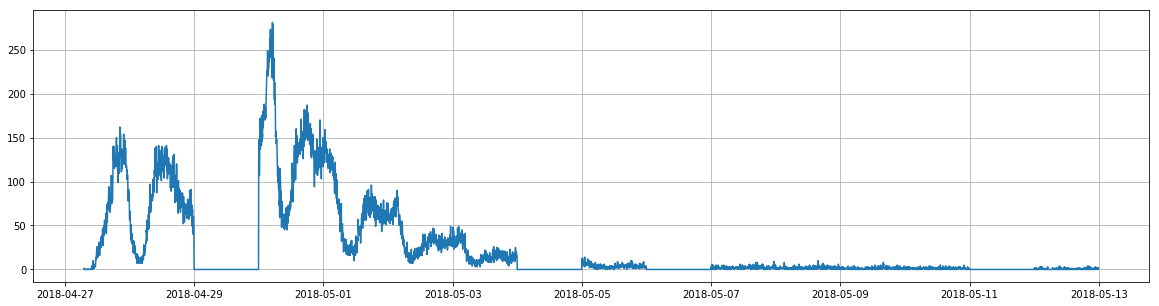

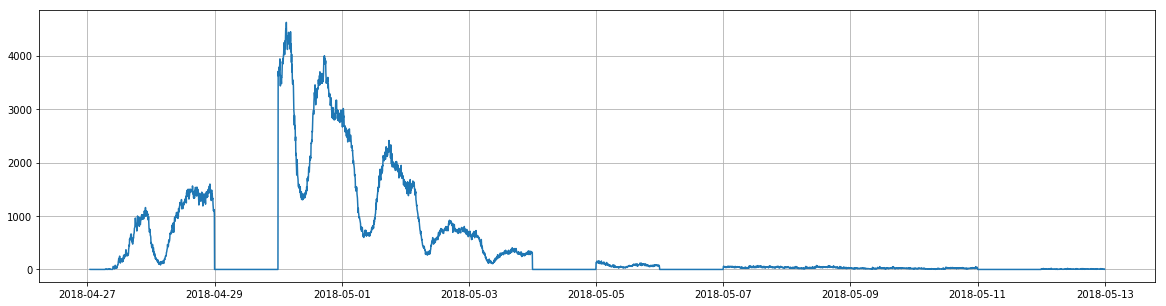

In [86]:
plt.figure(figsize=(20, 5))
plt.plot(originals[['created_at','retweet_count']].set_index('created_at').resample('5T').count())
plt.grid(True)
plt.show()

plt.figure(figsize=(20, 5))
plt.plot(df[['created_at','retweet_count']].set_index('created_at').resample('5T').count())
plt.grid(True)
plt.show()


In [87]:
with_content_ids_set=set(list(originals.id.values)+list(quotes.id.values)+list(replies.id.values))
print ("Tweets with content: ",len(with_content_ids_set))
print ("From which retweeted: ",len(with_content_ids_set.intersection(set(retweets.parent_id.values))))
print ("These are left ",len(set(list(retweets.parent_id.values)+list(replies.parent_id.values)+list(quotes.parent_id.values)).difference(with_content_ids_set))," tweets with content")
print ("Moreover, in the database they mention ",len(df.parent_id.unique())," tweets that add to ",df[df.parent_id>0].groupby('parent_id')['retweet_count'].max().sum()," retweets")

Tweets with content:  138795
From which retweeted:  57231
These are left  14057  tweets with content
Moreover, in the database they mention  77735  tweets that add to  2787585  retweets


The ones that are lacking are the ones on the missing days?

In [88]:
originals.head()

,country,created_at,favorite_count,full_text,id,lat,location,lon,parent_country,parent_created_at,parent_favorite_count,parent_full_text,parent_id,parent_lat,parent_location,parent_lon,parent_place,parent_quote_count,parent_retweet_count,parent_time_zone,parent_user_created_at,parent_user_followers_count,parent_user_id,parent_user_name,parent_user_screen_name,parent_user_statuses_count,place,quote_count,retweet_count,time_zone,tweet_type,user_created_at,user_followers_count,user_id,user_name,user_screen_name,user_statuses_count
990380122082611200,None,2018-04-28 23:59:56,1,17 años.Vuelvo a casa con miedo. Se me acerca ...,990380122082611200,-999.0,,-999.0,None,NaT,-1,None,0,-999.0,None,-999.0,None,-1,-1,None,NaT,-1,0,None,None,-1,None,-1,0,Hawaii,original,2011-11-11 14:33:11,78,410012730,Angela♀,Angelasantos002,3126
990380024703447040,None,2018-04-28 23:59:32,1,#Cuéntalo como hacéis las lentejas?,990380024703447040,-999.0,Cocretas del Bar,-999.0,None,NaT,-1,None,0,-999.0,None,-999.0,None,-1,-1,None,NaT,-1,0,None,None,-1,None,-1,0,None,original,2016-08-17 15:01:47,223,765926604400910337,ƇƛƤƖƬƛ́Ɲ ƇƠƇƦЄƬƛ ♰,capitancocreta,8478
990380009549434882,None,2018-04-28 23:59:29,0,un grupo de amigas nos reunimos y salio la pla...,990380009549434882,-999.0,in they heart,-999.0,None,NaT,-1,None,0,-999.0,None,-999.0,None,-1,-1,None,NaT,-1,0,None,None,-1,None,-1,0,Central Time (US & Canada),original,2014-02-10 01:21:33,1196,2335901545,ßæ ◟̽◞̽,lapijadezayn_,13079
990380001202761728,None,2018-04-28 23:59:27,5,Volvía a casa de la universidad. En el autobús...,990380001202761728,-999.0,MADRID,-999.0,None,NaT,-1,None,0,-999.0,None,-999.0,None,-1,-1,None,NaT,-1,0,None,None,-1,None,-1,3,Athens,original,2011-10-23 19:41:46,309,396794973,María.,MariaRodas7,6831
990379986564669441,None,2018-04-28 23:59:23,0,"Ninguna situación, por más pequeña que sea deb...",990379986564669441,-999.0,Friendzone,-999.0,None,NaT,-1,None,0,-999.0,None,-999.0,None,-1,-1,None,NaT,-1,0,None,None,-1,None,-1,0,None,original,2017-03-06 15:53:59,15,838779702445805568,Blanco y negro,RainbowCloudBW,293


What's the average number of RT per retweeted tweet?

In [89]:
retweeted_ids_with_maxcounts.mean()

44.45566684917389

What's the variance?

In [90]:
retweeted_ids_with_maxcounts.std()

568.9743774456562

In [91]:
from scipy.stats import poisson
from scipy.special import factorial
import numpy as np
from scipy.optimize import curve_fit

In [93]:
cutoff=100

Let's see the distribution of retweet counts...

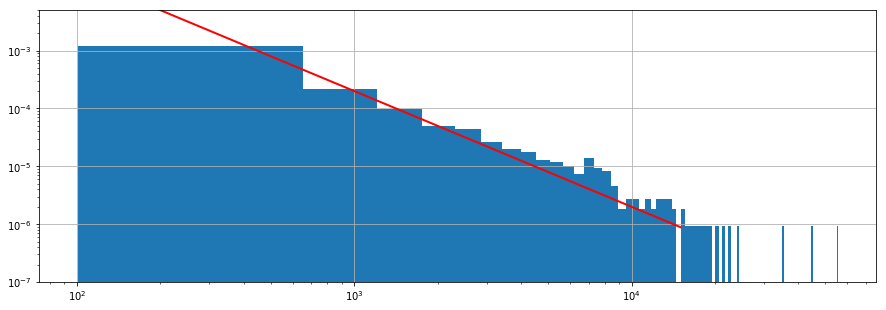

In [98]:
x_end = 15000
fig, ax = plt.subplots(figsize=(15, 5))
hist=retweeted_ids_with_maxcounts[retweeted_ids_with_maxcounts>cutoff].hist(bins=100,density=True)
x_plot = np.linspace(cutoff, x_end, 1000)

def wonk(vec,lam):
    return np.power(vec,-lam)*200 

plt.plot(x_plot, wonk(x_plot, 2), 'r-', lw=2)  #### Roughly Power 2???
ax.set_yscale('log')
ax.set_xscale('log')
plt.ylim((1e-7,5e-3))
plt.show()

In [99]:
retweeted_ids_with_maxcounts[retweeted_ids_with_maxcounts>20000]

parent_id
990201907456208896    55482
990534847604064256    21568
990542133802274816    23924
990775116807229440    20485
990818114995703808    22676
991217730601848834    44786
991464409825505280    35531
Name: retweet_count, dtype: int32

In [103]:
tw=df[df.id.isin(retweeted_ids_with_maxcounts[retweeted_ids_with_maxcounts>10000].index)]
tw[['user_followers_count','retweet_count']].sort_values('retweet_count',ascending=False)[:20]

,user_followers_count,retweet_count
990201907456208896,1148,54705
991217730601848834,2543,44150
991464409825505280,2238,33892
990818114995703808,591,22633
990775116807229440,718,20483
990779462273953794,1344,17764
990325049893801984,5825,17472
991034153268383751,761,17195
990864702011006977,386,16094
990285709293572096,893,15873


### Who is who

In [120]:
grouped_retweets.sum().columns

Index(['favorite_count', 'id', 'lat', 'lon', 'parent_favorite_count',
       'parent_lat', 'parent_lon', 'parent_quote_count',
       'parent_retweet_count', 'parent_user_followers_count', 'parent_user_id',
       'parent_user_statuses_count', 'quote_count', 'retweet_count',
       'user_followers_count', 'user_id', 'user_statuses_count'],
      dtype='object')

In [123]:
followers_and_retweets=pd.DataFrame()
followers_and_retweets['retweet_count']=grouped_retweets[['retweet_count','parent_id','parent_user_followers_count']].max().groupby('parent_id')['retweet_count'].sum()
followers_and_retweets['user_followers']=grouped_retweets[['retweet_count','parent_id','parent_user_followers_count']].max().groupby('parent_id')['parent_user_followers_count'].mean()

/Users/fserra/anaconda3/envs/context_deep_learning/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: 'parent_id' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  
/Users/fserra/anaconda3/envs/context_deep_learning/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 'parent_id' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  This is separate from the ipykernel package so we can avoid doing imports until


<Figure size 1080x720 with 0 Axes>

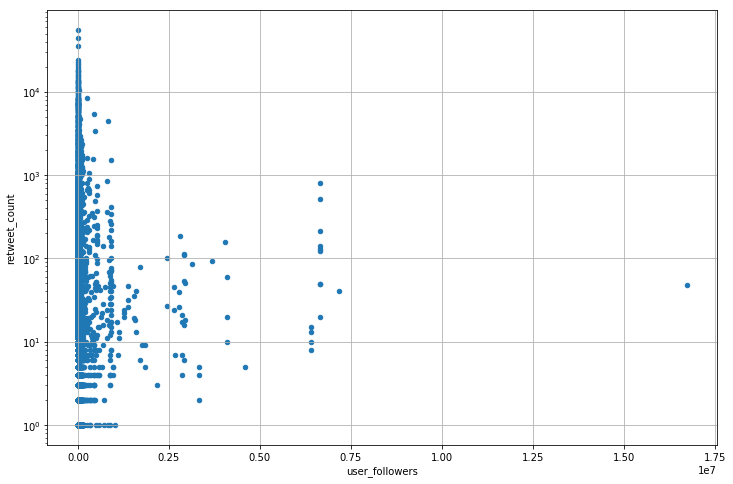

In [133]:
plt.figure(figsize=(15, 10))
followers_and_retweets.plot.scatter(x='user_followers',y='retweet_count',figsize=(12,8)).set_yscale("log")
plt.grid(True)
plt.show()

Most retweets are for people with few followers.

Using logarithmic ranges.

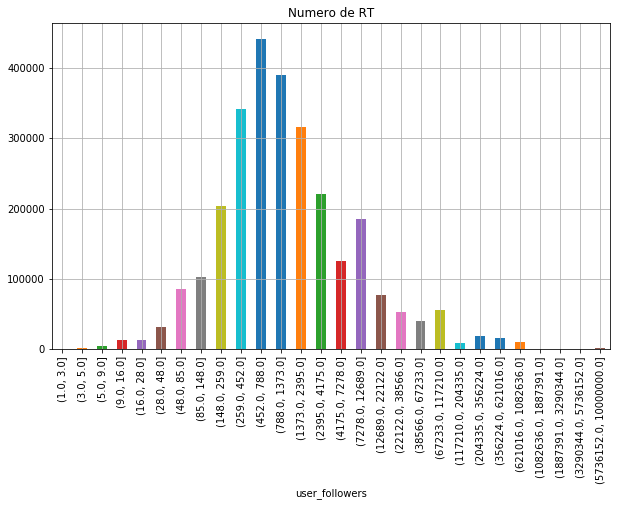

In [132]:
divisiones=np.unique(np.floor(np.logspace(0,7, num=30)))
plt.figure(figsize=(16, 8))
followers_and_retweets.groupby(pd.cut(followers_and_retweets['user_followers'], divisiones))['retweet_count'].sum().plot.bar(figsize=(10,6),title='Numero de RT')
plt.grid(True)
plt.show()

That's why these are similar to the quantity of users per bin

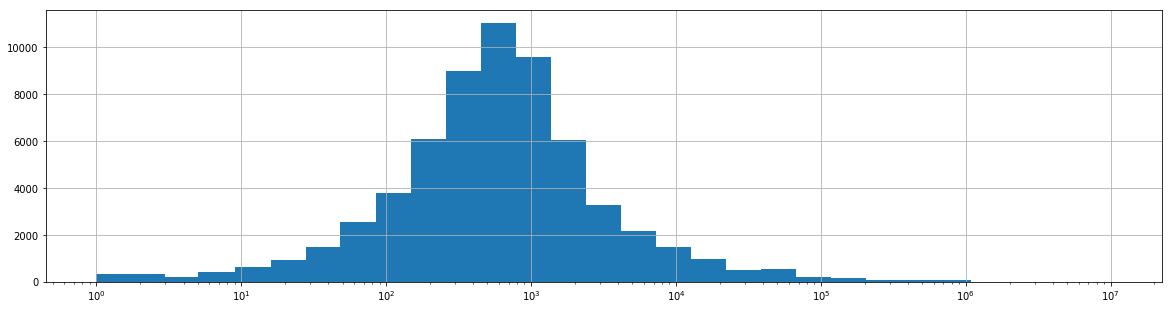

In [135]:
plt.figure(figsize=(20, 5))
followers_and_retweets['user_followers'].hist(bins=divisiones).set_xscale("log")
plt.grid(True)
plt.show()

In [136]:
rt_count=followers_and_retweets.groupby(pd.cut(followers_and_retweets['user_followers'], divisiones))['retweet_count'].sum()
user_count=followers_and_retweets.groupby(pd.cut(followers_and_retweets['user_followers'], divisiones))['user_followers'].count()
follower_count=followers_and_retweets.groupby(pd.cut(followers_and_retweets['user_followers'], divisiones))['user_followers'].sum()

In [137]:
agregados_por_rango=pd.DataFrame({"user_count":user_count,"retweet_count/40":rt_count/40, "followers": follower_count})
agregados_por_rango

,user_count,retweet_count/40,followers
user_followers,,,
"(1.0, 3.0]",270,19.250,648
"(3.0, 5.0]",238,33.525,1073
"(5.0, 9.0]",402,125.800,3010
"(9.0, 16.0]",611,323.800,7816
"(16.0, 28.0]",919,333.000,20497
"(28.0, 48.0]",1480,801.300,57163
"(48.0, 85.0]",2522,2145.500,169295
"(85.0, 148.0]",3805,2558.475,444376
"(148.0, 259.0]",6092,5084.125,1233049


<Figure size 1080x360 with 0 Axes>

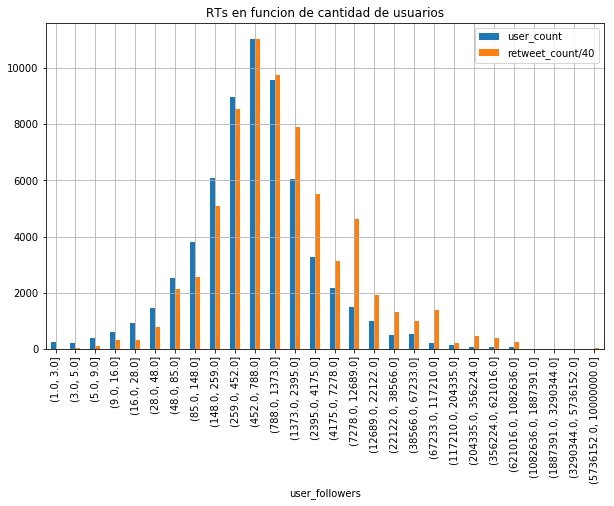

In [145]:
plt.figure(figsize=(15, 5))
agregados_por_rango[["user_count","retweet_count/40"]].plot.bar(figsize=(10,6),title='RTs en funcion de cantidad de usuarios')
plt.grid(True)
plt.show()

The quantity of retweets is because there are many users

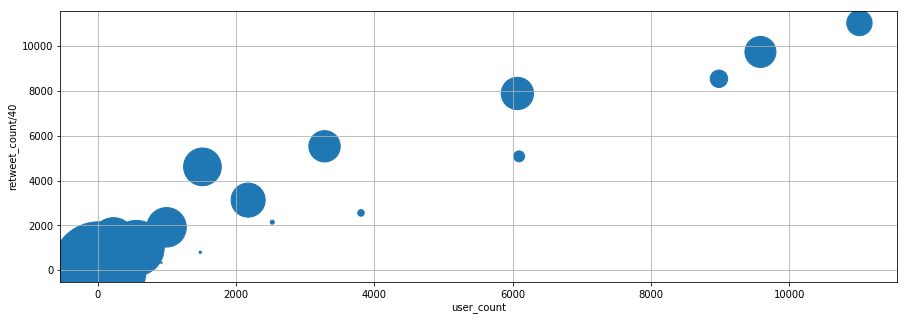

In [144]:
fig, ax = plt.subplots(figsize=(15, 5))
agregados_por_rango.plot.scatter(x="user_count",y="retweet_count/40",s=np.power(0.25*np.sqrt(follower_count/648),2), ax=ax)
plt.grid(True)
plt.show()

Apparently most of users do not have a very big number of retweets.

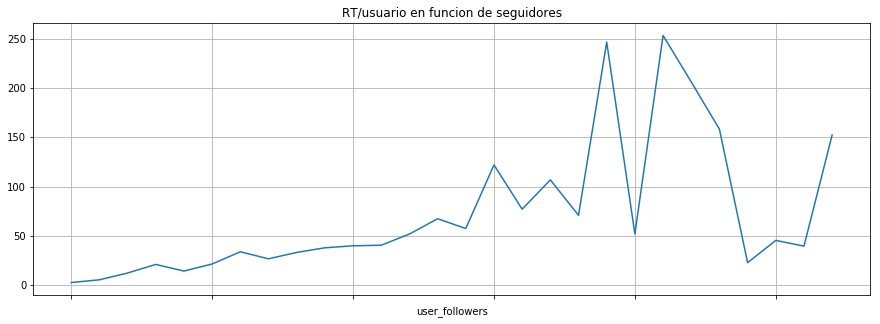

In [143]:
plt.figure(figsize=(15, 5))
(rt_count/user_count).plot(title="RT/usuario en funcion de seguidores")
plt.grid(True)
plt.show()